### Libraries

In [1]:
import pandas as pd
from pandas import DatetimeIndex as dt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from pandas.plotting import scatter_matrix
from scipy import stats
import joblib

#### 1. Data Exploration and Preprocessing

In [2]:
sales = pd.read_csv('supermarket_sales.csv')

In [3]:
sales

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Total                    1000 non-null   float64
 9   Date                     1000 non-null   object 
 10  Time                     1000 non-null   object 
 11  Payment                  1000 non-null   object 
 12  cogs                     1000 non-null   float64
 13  gross margin percentage  1000 non-null   float64
 14  gross income             

In [5]:
sales.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Total', 'Date', 'Time',
       'Payment', 'cogs', 'gross margin percentage', 'gross income', 'Rating'],
      dtype='object')

In [6]:
#Changing Date and Column according to encoding requirements
sales['Date'] = pd.to_datetime(sales['Date']).dt.day_of_week

pd.to_datetime(sales['Time'])
pd.to_datetime(sales['Time']).dt.strftime('%H').astype('float')

sales['Time'] = pd.to_datetime(sales['Time']).dt.strftime('%H').astype('float')
sales['Time'] = pd.cut(sales['Time'], bins=[0., 12.0, 17.0, 19.0, np.inf], labels=[1, 2, 3, 4])

In [7]:
sales_regression = sales.drop(labels=['Invoice ID', 'Branch', 'Customer type', 'Gender','Product line','Payment','gross margin percentage'],axis=1)

In [8]:
corr_matrix = sales_regression.corr(method = 'pearson')
corr_matrix

,Unit price,Quantity,Total,Date,cogs,gross income,Rating
Unit price,1.000000,0.010778,0.633962,-0.007040,0.633962,0.633962,-0.008778
Quantity,0.010778,1.000000,0.705510,0.054770,0.705510,0.705510,-0.015815
Total,0.633962,0.705510,1.000000,0.038809,1.000000,1.000000,-0.036442
Date,-0.007040,0.054770,0.038809,1.000000,0.038809,0.038809,-0.013879
cogs,0.633962,0.705510,1.000000,0.038809,1.000000,1.000000,-0.036442
gross income,0.633962,0.705510,1.000000,0.038809,1.000000,1.000000,-0.036442
Rating,-0.008778,-0.015815,-0.036442,-0.013879,-0.036442,-0.036442,1.000000


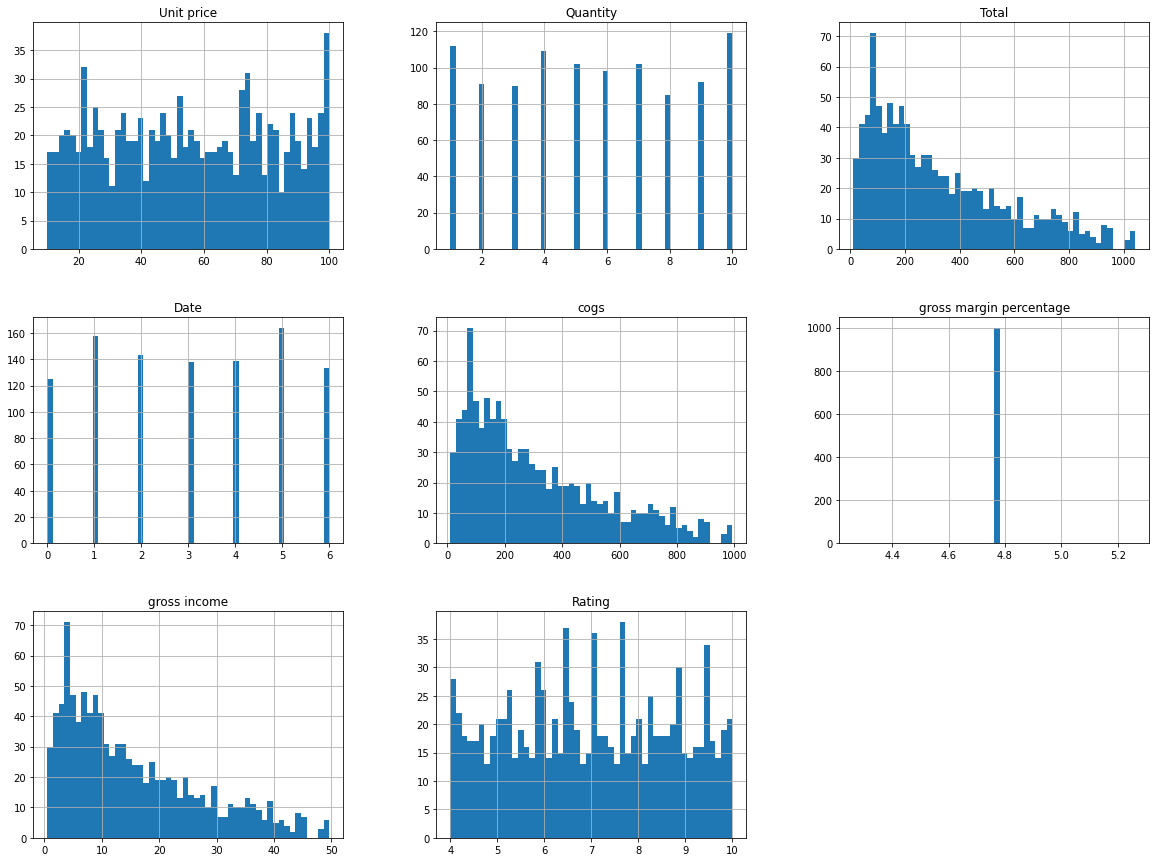

In [9]:
sales.hist(bins=50, figsize=(20,15));

/apps/python/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 4.761904762 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/apps/python/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 4.761904762 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/apps/python/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 4.761904762 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


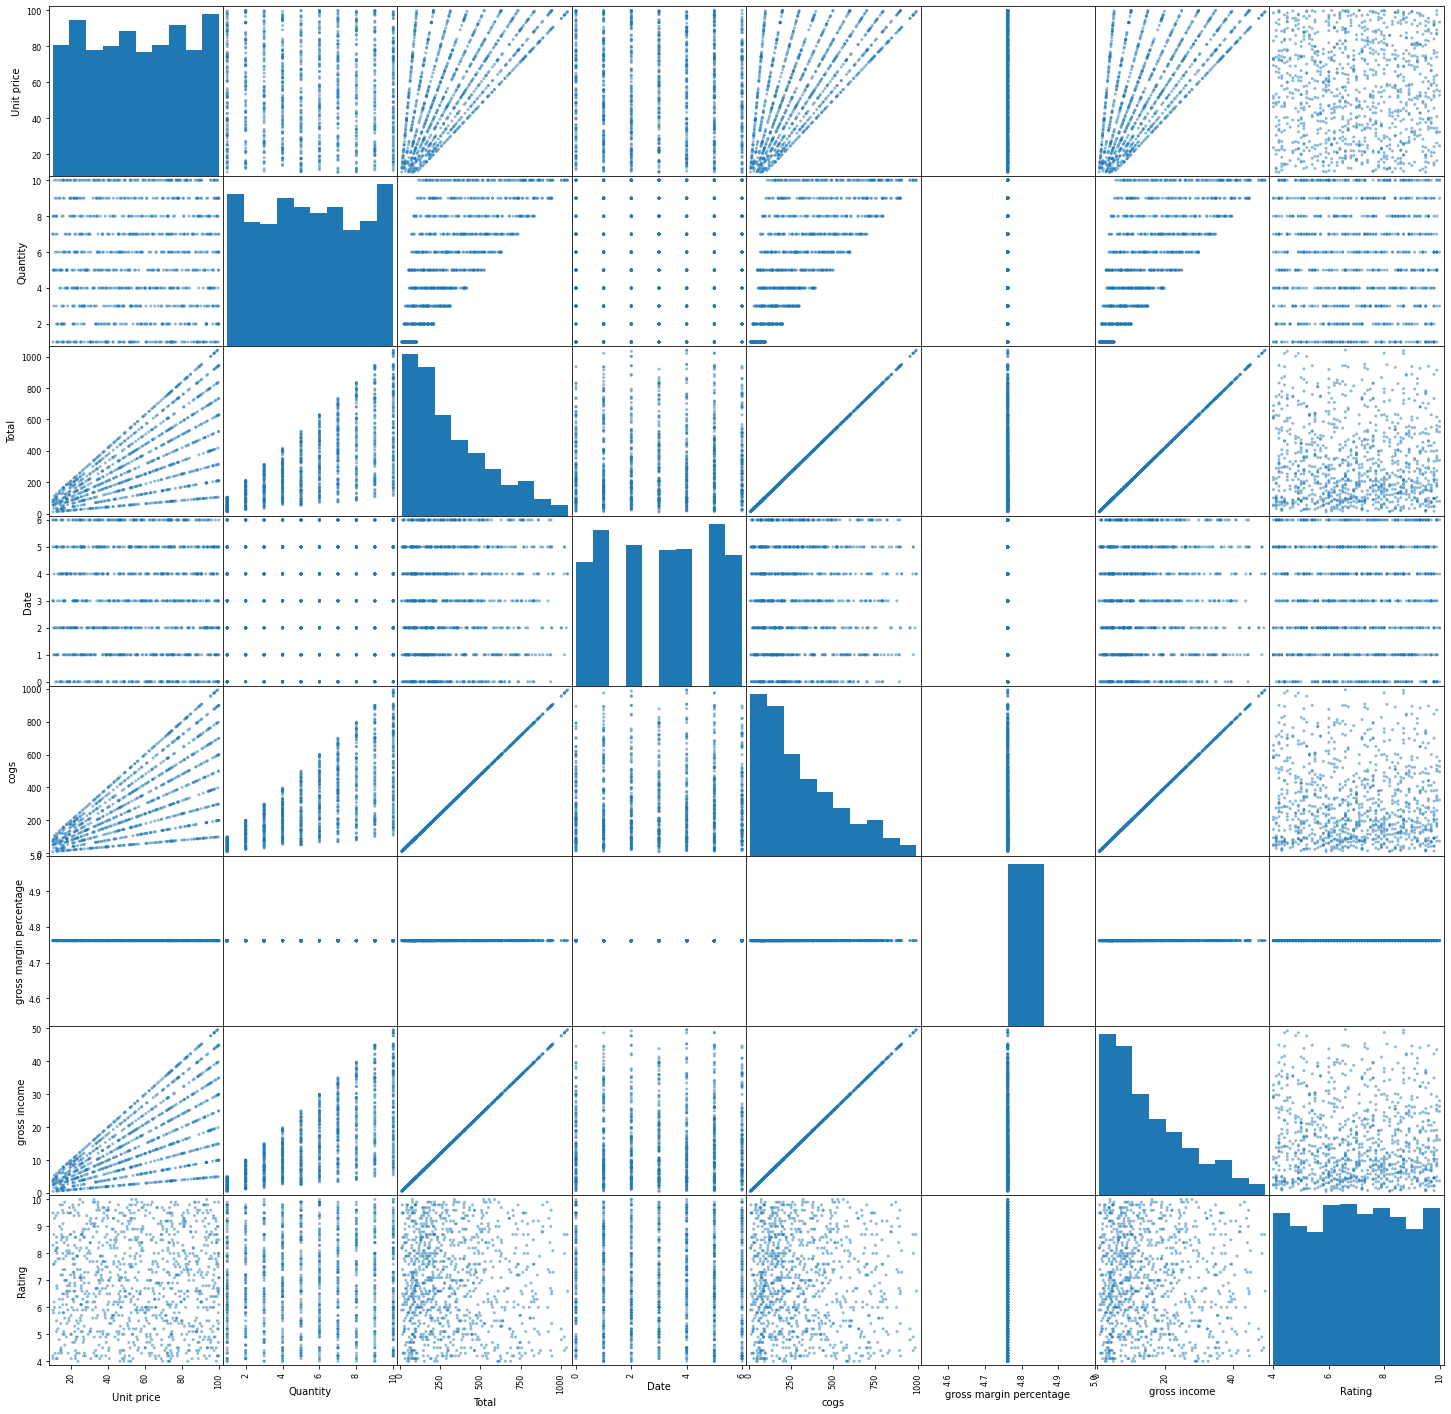

In [10]:
scatter_matrix(sales, figsize=(25,25));

### 2. To predict gross income

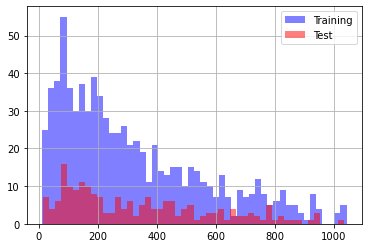

In [11]:
sales_income = sales.drop(labels=['Invoice ID', 'gross margin percentage','cogs'], axis = 1)
X = sales_income.drop(labels=['gross income'],axis=1)
t = sales_income[['gross income']]

train, test = train_test_split(sales, test_size = 0.2, random_state = 2,shuffle=True)
train['Total'].hist(bins=50, alpha=0.5, color='b', label='Training')
test['Total'].hist(bins=50,  alpha=0.5, color='r', label='Test')
plt.legend();

In [12]:
sales['Total'].describe()

count    1000.000000
mean      322.966749
std       245.885335
min        10.678500
25%       124.422375
50%       253.848000
75%       471.350250
max      1042.650000
Name: Total, dtype: float64

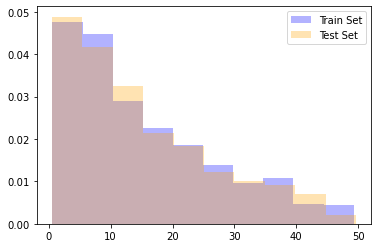

In [13]:
Total_cat = pd.cut(sales['Total'],
                   bins=[0,125,250,400,600, np.inf],
                   labels=[1, 2, 3, 4, 5])

X_train, X_test, t_train, t_test = train_test_split(X,t, stratify = Total_cat, test_size = 0.2, random_state = 2,shuffle=True)

plt.hist(t_train, density=True, color='blue', label='Train Set', alpha=0.3)
plt.hist(t_test, density=True, color='orange', label='Test Set', alpha=0.3)
plt.legend();

In [14]:
X

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,Rating
0,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,5,2,Ewallet,9.1
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,4,1,Cash,9.6
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,6,2,Credit card,7.4
3,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,6,4,Ewallet,8.4
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,4,1,Ewallet,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...
995,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,42.3675,1,2,Ewallet,6.2
996,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,1022.4900,5,2,Ewallet,4.4
997,A,Yangon,Member,Male,Food and beverages,31.84,1,33.4320,5,2,Cash,7.7
998,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,69.1110,4,2,Cash,4.1


In [15]:
cat_OH_attribs = ['Date', 'Time']
cat_OD_attribs = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
num_attribs = ['Unit price', 'Quantity', 'Total', 'Rating']


num_pipeline = Pipeline([('Scalar', StandardScaler())])
cat_OH_pipeline = Pipeline([('OneHotEnc', OneHotEncoder())])
cat_OD_pipeline = Pipeline([('OrdEnc', OrdinalEncoder())])


preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('OH_cat', cat_OH_pipeline, cat_OH_attribs),
                                 ('OD_cat', cat_OD_pipeline, cat_OD_attribs)])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('Scalar', StandardScaler())]),
                                 ['Unit price', 'Quantity', 'Total', 'Rating']),
                                ('OH_cat',
                                 Pipeline(steps=[('OneHotEnc',
                                                  OneHotEncoder())]),
                                 ['Date', 'Time']),
                                ('OD_cat',
                                 Pipeline(steps=[('OrdEnc', OrdinalEncoder())]),
                                 ['Branch', 'City', 'Customer type', 'Gender',
                                  'Product line', 'Payment'])])

#### Multiple Linear Regression without Lasso

In [16]:
lin_model = Pipeline([('prepro', preprocessor),
                         ('lin_reg', LinearRegression())])

lin_model.fit(X_train,t_train)

cv_scores  = cross_val_score(lin_model, X_train, t_train, cv=10, scoring='r2')

print("Validation Scores:", cv_scores)

joblib.dump(lin_model,'models/LinearReg.pkl')


Validation Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


['models/LinearReg.pkl']

Model is overfitting

#### Multiple Linear Regression with Lasso

In [17]:
lin_l1_model = Pipeline([('prepro', preprocessor),
                         ('lin_reg_lasso', Lasso())])
param_grid = {'lin_reg_lasso__alpha': np.linspace(0.0001, 0.2, 300)}

grid_lin_l1_model = GridSearchCV(lin_l1_model, param_grid, cv=5)

grid_lin_l1_model.fit(X_train,t_train)
grid_best_lin = grid_lin_l1_model.best_estimator_

grid_best_lin.fit(X_train,t_train)
grid_scores  = cross_val_score(grid_best_lin, X_train, t_train, cv=10, scoring='r2')

print("Validation Scores:", grid_scores)
print("Mean Validation Scores:", grid_scores.mean())

Validation Scores: [0.99999997 0.99999998 0.99999998 0.99999996 0.99999997 0.99999997
 0.99999997 0.99999997 0.99999998 0.99999998]
Mean Validation Scores: 0.9999999730468334


In [18]:
grid_best_lin.named_steps['lin_reg_lasso']

Lasso(alpha=0.0014371237458193982)

In [19]:
grid_best_lin.named_steps['lin_reg_lasso'].coef_

array([ 2.28689184e-03,  2.79006237e-03,  1.16498333e+01, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00])

Most Informative features:
Unit price
Quantity
Total


<StemContainer object of 3 artists>

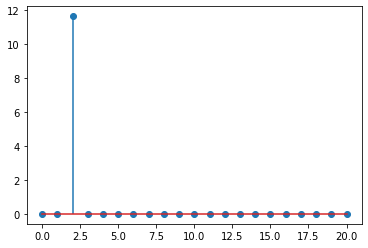

In [20]:
w = grid_best_lin.named_steps['lin_reg_lasso'].coef_

feat = 1*(w != 0)
columns = num_attribs + cat_OH_attribs + cat_OD_attribs

#Print most informative features, corresponding to the coefficients of w
print("Most Informative features:")
for i in range(feat.size):
    if feat[i]:
        print(columns[i])
        
plt.stem(w)

In [21]:
confidence = 0.95

print('95% CI: ', stats.t.interval(confidence, len(grid_scores) - 1,
                 loc=grid_scores.mean(),
                 scale=grid_scores.std(ddof=1)/np.sqrt(len(grid_scores))))

joblib.dump(grid_best_lin,'models/LinearReg_tuned_income.pkl')

95% CI:  (0.9999999689769009, 0.9999999771167659)


['models/LinearReg_tuned_income.pkl']

### 3. To predict Unit Price

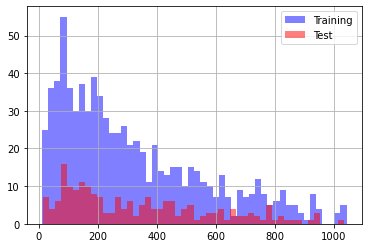

In [22]:
X = sales_income.drop(labels=['Unit price','City'],axis=1)
t = sales_income[['Unit price']]

train, test = train_test_split(sales, test_size = 0.2, random_state = 2,shuffle=True)
train['Total'].hist(bins=50, alpha=0.5, color='b', label='Training')
test['Total'].hist(bins=50, alpha=0.5, color='r', label='Test')
plt.legend();

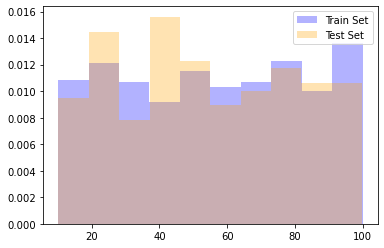

In [23]:
Total_cat = pd.cut(sales['Total'],
                   bins=[0,125,250, 470, np.inf],
                   labels=[1, 2, 3, 4])

X_train, X_test, t_train, t_test = train_test_split(X,t, stratify = Total_cat, test_size = 0.2, random_state = 2,shuffle=True)

plt.hist(t_train,density = True, color='blue', label='Train Set', alpha=0.3)
plt.hist(t_test,density = True, color='orange', label='Test Set', alpha=0.3)
plt.legend();

In [24]:
cat_OH_attribs = ['Date', 'Time','Product line','Payment']
cat_OD_attribs = ['Branch', 'Customer type', 'Gender']
num_attribs = [ 'Quantity', 'Total','gross income', 'Rating']

num_pipeline = Pipeline([('Scalar', StandardScaler())])
cat_OH_pipeline = Pipeline([('OneHotEnc', OneHotEncoder())])
cat_OD_pipeline = Pipeline([('OrdEnc', OrdinalEncoder())])

preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('OH_cat', cat_OH_pipeline, cat_OH_attribs),
                                 ('OD_cat', cat_OD_pipeline, cat_OD_attribs)])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('Scalar', StandardScaler())]),
                                 ['Quantity', 'Total', 'gross income',
                                  'Rating']),
                                ('OH_cat',
                                 Pipeline(steps=[('OneHotEnc',
                                                  OneHotEncoder())]),
                                 ['Date', 'Time', 'Product line', 'Payment']),
                                ('OD_cat',
                                 Pipeline(steps=[('OrdEnc', OrdinalEncoder())]),
                                 ['Branch', 'Customer type', 'Gender'])])

#### Multiple Linear Regression without Lasso

In [25]:
lin_model = Pipeline([('prepro', preprocessor),
                         ('lin_reg', LinearRegression())])

lin_model.fit(X_train,t_train)

cv_scores  = cross_val_score(lin_model, X_train, t_train, cv=10, scoring='r2')

print("Validation Scores:", cv_scores)

confidence = 0.95

print('95% CI: for Training without Lasso regularization', stats.t.interval(confidence, len(cv_scores) - 1,
                 loc=cv_scores.mean(),
                 scale=cv_scores.std(ddof=1)/np.sqrt(len(cv_scores))))

print("Mean Validation Scores:", cv_scores.mean())

Validation Scores: [0.74275103 0.77580456 0.8028165  0.74971787 0.80781343 0.78740686
 0.75249493 0.74920642 0.77086444 0.74149922]
95% CI: for Training without Lasso regularization (0.7503362845495193, 0.7857387686604388)
Mean Validation Scores: 0.768037526604979


#### Multiple Linear Regression with Lasso

In [26]:
lin_l1_model = Pipeline([('prepro', preprocessor),
                         ('lin_reg_lasso', Lasso())])
param_grid = {'lin_reg_lasso__alpha': np.linspace(0.2, 0.5, 300)}

grid_lin_l1_model = GridSearchCV(lin_l1_model, param_grid, cv=5)

grid_lin_l1_model.fit(X_train,t_train)
grid_best_lin = grid_lin_l1_model.best_estimator_

grid_best_lin.fit(X_train,t_train)
grid_scores  = cross_val_score(grid_best_lin, X_train, t_train, cv=10, scoring='r2')

print("Validation Scores:", grid_scores)

print("Mean Validation Scores:", grid_scores.mean())
joblib.dump(lin_model,'models/LinearReg_UnitPrice.pkl')

Validation Scores: [0.74970396 0.77572712 0.79434469 0.7531     0.80803436 0.80426041
 0.76626558 0.75823081 0.79336445 0.7467894 ]
Mean Validation Scores: 0.7749820778511959


['models/LinearReg_UnitPrice.pkl']

In [27]:
grid_best_lin.named_steps['lin_reg_lasso']

Lasso(alpha=0.36153846153846153)

Most Informative features:
Quantity
Total
gross income
Rating
Credit card


<StemContainer object of 3 artists>

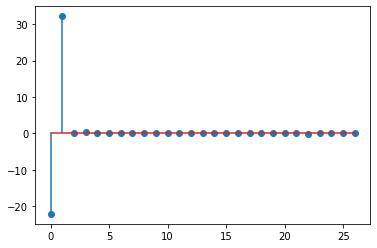

In [28]:
OH_encoding = np.concatenate(grid_best_lin.named_steps['prepro'].named_transformers_['OH_cat']['OneHotEnc'].categories_)
w = grid_best_lin.named_steps['lin_reg_lasso'].coef_

feat = 1*(w != 0)
columns = num_attribs + list(OH_encoding) + cat_OD_attribs

#Print most informative features, corresponding to the coefficients of w
print("Most Informative features:")
for i in range(feat.size):
    if feat[i]:
        print(columns[i])
plt.stem(w)    

In [29]:
grid_best_lin.named_steps['lin_reg_lasso'].coef_

array([-2.21219971e+01,  3.21668485e+01,  7.60280727e-15,  4.09380303e-01,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.39234912e-01,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00])

In [30]:
print('95% CI: for Training with Lasso regularization ', stats.t.interval(confidence, len(grid_scores) - 1,
                 loc=grid_scores.mean(),
                 scale=grid_scores.std(ddof=1)/np.sqrt(len(grid_scores))))

print("Mean Validation Scores:", grid_scores.mean())

joblib.dump(grid_best_lin,'models/LinearReg_tuned_UnitPrice.pkl')

95% CI: for Training with Lasso regularization  (0.7582355458700891, 0.7917286098323026)
Mean Validation Scores: 0.7749820778511959


['models/LinearReg_tuned_UnitPrice.pkl']

#### 4. Logistic Regression to Classify Gender

In [31]:
sales_class = sales.drop(labels=['Invoice ID','gross margin percentage'],axis=1)
cat_enc = OrdinalEncoder()
t = cat_enc.fit_transform(sales_class[['Gender']]).ravel()
X = sales_class.drop(labels=['Gender'],axis=1)

X_train, X_test, t_train, t_test = train_test_split(X,t, stratify = t, test_size = 0.2, random_state = 2,shuffle=True)

num_pipeline = Pipeline([('Scalar', StandardScaler())])
cat_pipeline = Pipeline([('OneHot', OneHotEncoder())])

num_attribs = ['Unit price', 'Quantity', 'Total','cogs','gross income', 'Rating']
cat_attribs = ['Branch', 'Customer type', 'Product line', 'Payment', 'Date', 'Time']

preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', cat_pipeline, cat_attribs)])

pipe = Pipeline([('prepro', preprocessor),
                ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
                ('log_reg', LogisticRegression(penalty='l1', solver='liblinear'))])

param_grid = {'log_reg__C': np.linspace(0.01,1,50)}

grid_search = GridSearchCV(pipe, param_grid, scoring='r2', refit=True, cv=5)

grid_search.fit(X_train, t_train)

log_reg_tuned = grid_search.best_estimator_.fit(X_train,t_train)
joblib.dump(log_reg_tuned,'models/LogReg_Gender.pkl')

y_train = log_reg_tuned.predict(X_train)
print('Training Set:\n', classification_report(t_train, y_train))

print("Tuned Hyperparameter:",grid_search.best_params_)

Training Set:
               precision    recall  f1-score   support

         0.0       0.61      0.58      0.60       401
         1.0       0.60      0.63      0.61       399

    accuracy                           0.60       800
   macro avg       0.61      0.61      0.60       800
weighted avg       0.61      0.60      0.60       800

Tuned Hyperparameter: {'log_reg__C': 0.13122448979591836}


,Attributes,Coefficients
20,Ewallet,0.15414278091833625
192,Rating + 6,0.1498138151780989
241,B + 2,0.12877283161487268
54,Unit price + 3,0.08758865735850462
39,Unit price + C,0.07365328608495325
...,...,...
34,Unit price + cogs,-0.021266854531567254
18,Cash,-0.013350690041604668
33,Unit price + Total,-0.011669526347521436
156,gross income + Home and lifestyle,-0.009816105909437146


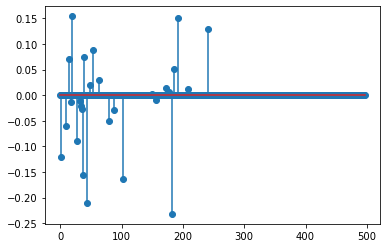

In [32]:
OH_encoding = np.concatenate(log_reg_tuned.named_steps['prepro'].named_transformers_['cat']['OneHot'].categories_)
poly_attributes = ['Intercept']
N_attributes = log_reg_tuned.named_steps['poly_feat'].powers_.shape[0]
attrib_names = np.array(num_attribs + list(OH_encoding))
w = log_reg_tuned.named_steps['log_reg'].coef_

for i in range(1,N_attributes):
    temp = attrib_names[log_reg_tuned.named_steps['poly_feat'].powers_[i,:]==1]

    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)

relations = pd.DataFrame(np.hstack((poly_attributes, w.T)), columns=['Attributes', 'Coefficients'])

relations_sorted = relations.sort_values(by='Coefficients', ascending=False)
plt.stem(log_reg_tuned.named_steps['log_reg'].coef_.T)
relations_sorted

In [33]:
# Get Only Branch C samples
sales_branchC = sales_class[sales_class['Branch'] == 'C']
# gender, product line, payment and gross income
attrib_names = np.array([ 'Product line', 'Payment', 'gross income'])

X = sales_branchC[attrib_names]
t = cat_enc.fit_transform(sales_branchC[['Gender']]).ravel()

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=2, shuffle = True, stratify = t)

num_attribs = ['gross income']
cat_attribs = [ 'Product line', 'Payment']

cat_pipeline = Pipeline([('OD', OrdinalEncoder())])
preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', cat_pipeline, cat_attribs)])

pipe = Pipeline([('prepro', preprocessor),
                ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
                ('log_reg', LogisticRegression(tol=2, fit_intercept=True))])

pipe.fit(X_train, t_train)



poly_attributes = ['Intercept']
N_attributes = pipe.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[pipe.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)
w = pipe.named_steps['log_reg'].coef_.T

relations = pd.DataFrame(np.hstack((poly_attributes, w)), columns=['Attributes', 'Coefficients'])
relations

,Attributes,Coefficients
0,Intercept,0.018069120135622303
1,Product line,0.08068228680515441
2,Payment,-0.13440659590883033
3,gross income,0.06777549816044512
4,Product line + Payment,-0.1120007209166997
5,Product line + gross income,0.02783299419729159
6,Payment + gross income,0.009975226159205871


#### 5. Logistic regression to classify customer type

In [34]:
sales_class = sales.drop(labels=['Invoice ID','gross margin percentage'],axis=1)
cat_enc = OrdinalEncoder()
t = cat_enc.fit_transform(sales_class[['Customer type']]).ravel()
X = sales_class.drop(labels=['Customer type'],axis=1)

X_train, X_test, t_train, t_test = train_test_split(X,t, stratify = t, test_size = 0.2, random_state = 2,shuffle=True)

num_pipeline = Pipeline([('Scalar', StandardScaler())])
cat_pipeline = Pipeline([('OneHot', OneHotEncoder())])

num_attribs = ['Unit price', 'Quantity', 'Total','cogs','gross income', 'Rating']
cat_attribs = ['Branch', 'Gender', 'Product line', 'Payment', 'Date', 'Time']

preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', cat_pipeline, cat_attribs)])

pipe = Pipeline([('prepro', preprocessor),
                ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
                ('log_reg', LogisticRegression(penalty='l1', solver='liblinear'))])

param_grid = {'log_reg__C': np.linspace(0.01,1,50)}

grid_search = GridSearchCV(pipe, param_grid, scoring='r2', refit=True, cv=5)

grid_search.fit(X_train, t_train)

log_reg_tuned = grid_search.best_estimator_.fit(X_train,t_train)
joblib.dump(log_reg_tuned,'models/LogReg_CustomerType.pkl')

y_train = log_reg_tuned.predict(X_train)
print('Training Set:\n', classification_report(t_train, y_train))
print("Tuned Hyperparameter:",grid_search.best_params_)

Training Set:
               precision    recall  f1-score   support

         0.0       0.71      0.72      0.72       401
         1.0       0.72      0.71      0.71       399

    accuracy                           0.71       800
   macro avg       0.72      0.71      0.71       800
weighted avg       0.72      0.71      0.71       800

Tuned Hyperparameter: {'log_reg__C': 0.6969387755102041}


,Attributes,Coefficients
113,Total + 5,2.9264391946516933e-06
138,cogs + 3,1.4086604328789751e-05
368,Health and beauty + 2,0.9553525666774665
401,Sports and travel + 6,0.9425457893574831
330,Fashion accessories + Cash,0.7343482159411243
...,...,...
30,3,-0.0016726563021946794
129,cogs + Health and beauty,-0.0007953607511660371
35,Unit price + gross income,-0.0007765626817309048
102,Total + Health and beauty,-0.0002273433372983267


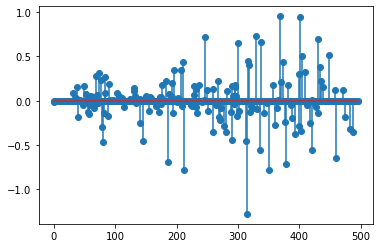

In [35]:
OH_encoding = np.concatenate(log_reg_tuned.named_steps['prepro'].named_transformers_['cat']['OneHot'].categories_)
poly_attributes = ['Intercept']
N_attributes = log_reg_tuned.named_steps['poly_feat'].powers_.shape[0]
attrib_names = np.array(num_attribs + list(OH_encoding))
w = log_reg_tuned.named_steps['log_reg'].coef_

for i in range(1,N_attributes):
    temp = attrib_names[log_reg_tuned.named_steps['poly_feat'].powers_[i,:]==1]

    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)

relations = pd.DataFrame(np.hstack((poly_attributes, w.T)), columns=['Attributes', 'Coefficients'])

relations_sorted = relations.sort_values(by='Coefficients', ascending=False)
plt.stem(log_reg_tuned.named_steps['log_reg'].coef_.T)
relations_sorted

In [36]:
# Get Only Branch C samples
sales_branchC = sales_class[sales_class['Branch'] == 'C']
# gender, product line, payment and gross income
attrib_names = np.array([ 'Gender', 'Date', 'Time'])

X = sales_branchC[attrib_names]
t = cat_enc.fit_transform(sales_branchC[['Customer type']]).ravel()

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=2, shuffle = True, stratify = t)

cat_attribs = [ 'Gender', 'Date', 'Time']

cat_pipeline = Pipeline([('OD', OrdinalEncoder())])
preprocessor = ColumnTransformer([('cat', cat_pipeline, cat_attribs)])

pipe = Pipeline([('prepro', preprocessor),
                ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
                ('log_reg', LogisticRegression(tol=2, fit_intercept=True))])

pipe.fit(X_train, t_train)


poly_attributes = ['Intercept']
N_attributes = pipe.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[pipe.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)
w = pipe.named_steps['log_reg'].coef_.T

relations = pd.DataFrame(np.hstack((poly_attributes, w)), columns=['Attributes', 'Coefficients'])
relations

,Attributes,Coefficients
0,Intercept,-0.004550645875186251
1,Gender,0.00518476611501931
2,Date,-0.00044484817314933544
3,Time,-0.0053481170470893276
4,Gender + Date,0.013754064750898638
5,Gender + Time,0.0006356533457481656
6,Date + Time,-0.014044474749291592


#### 6. Train a classifier to predict the day of purchase

In [17]:
sales_class_day = sales.drop(labels=['Invoice ID','gross margin percentage'],axis=1)
X = sales_class_day.drop(labels=['Date'],axis=1)
t = sales_class_day['Date']

In [38]:
X

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Time,Payment,cogs,gross income,Rating
0,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,2,Ewallet,522.83,26.1415,9.1
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,1,Cash,76.40,3.8200,9.6
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,2,Credit card,324.31,16.2155,7.4
3,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,4,Ewallet,465.76,23.2880,8.4
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,1,Ewallet,604.17,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,42.3675,2,Ewallet,40.35,2.0175,6.2
996,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,1022.4900,2,Ewallet,973.80,48.6900,4.4
997,A,Yangon,Member,Male,Food and beverages,31.84,1,33.4320,2,Cash,31.84,1.5920,7.7
998,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,69.1110,2,Cash,65.82,3.2910,4.1


In [31]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=2, shuffle = True, stratify = t)


num_attribs = ['Unit price', 'Quantity', 'Total', 'Time', 'cogs', 'gross income', 'Rating']
cat_attribs = ['Gender', 'Product line', 'Payment','Branch', 'City','Customer type']

cat_pipeline = Pipeline([('OD', OrdinalEncoder())])
preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', cat_pipeline, cat_attribs)])

pipe = Pipeline([('prepro', preprocessor),
                ('RF', RandomForestClassifier())])

pipe.fit(X_train, t_train)

# param_dist = {
#     'RF__n_estimators': np.arange(50, 200, 10),
#     'RF__criterion': ['gini', 'entropy'],
#     'RF__max_depth': np.arange(1,10),
#     'RF__min_samples_split': [2, 5, 10],
#     'RF__min_samples_leaf': [1, 2, 4],
#     'RF__bootstrap': [True, False]
# }

# random_search = RandomizedSearchCV(
#     pipe, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1
# )


param_grid = {'RF__n_estimators': [50,100,200,300,500],
              'RF__criterion': ['entropy','gini'],
              'RF__max_depth': np.arange(1,5),
              'RF__min_samples_split': np.arange(2,5),
              'RF__min_samples_leaf':np.arange(1,5)}

grid_search = GridSearchCV(pipe, param_grid, 
                           cv=5, scoring='accuracy', refit=True)

# Fit the model to your training data
# random_search.fit(X_train, y_train)

grid_search.fit(X_train, t_train)
final_model = grid_search.best_estimator_
# final_model = random_search.best_estimator_


y_train = final_model.predict(X_train)

print(classification_report(t_train, y_train))
joblib.dump(final_model,'models/RandomForest_Day.pkl')

              precision    recall  f1-score   support

           0       0.77      0.10      0.18       100
           1       0.23      0.61      0.34       126
           2       0.71      0.15      0.25       114
           3       0.46      0.16      0.24       111
           4       0.75      0.19      0.30       111
           5       0.27      0.70      0.39       131
           6       0.79      0.18      0.29       107

    accuracy                           0.32       800
   macro avg       0.57      0.30      0.28       800
weighted avg       0.55      0.32      0.29       800



['models/RandomForest_Day.pkl']

In [ ]:
#Logistic Regression

In [ ]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=2, shuffle = True, stratify = t)

num_attribs = ['Unit price', 'Quantity', 'Total', 'Time', 'cogs', 'gross income', 'Rating']
cat_attribs = ['Gender', 'Product line', 'Payment','Branch', 'City','Customer type']

cat_pipeline = Pipeline([('OD', OrdinalEncoder())])
preprocessor = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', cat_pipeline, cat_attribs)])

pipe_log = Pipeline([('prepro', preprocessor),
                ('LR', LogisticRegression(multi_class='multinomial', solver='lbfgs'))])

param_grid = {'LR__C': np.linspace(1,10,100)}

grid_search = GridSearchCV(pipe_log, param_grid, scoring='accuracy', refit=True, cv=10)

grid_search.fit(X_train, t_train)
final_model_LR = grid_search.best_estimator_

y_train = final_model_LR.predict(X_train)

print(classification_report(t_train, y_train))

In [ ]:
grid_search.best_params_

In [32]:
joblib.dump(final_model_LR,'models/LogReg_Day.pkl')

['models/LogReg_Day.pkl']

In [24]:
print(classification_report(t_train, y_train))

              precision    recall  f1-score   support

           0       0.19      0.17      0.18       100
           1       0.19      0.24      0.21       126
           2       0.26      0.25      0.26       114
           3       0.23      0.20      0.21       111
           4       0.23      0.12      0.15       111
           5       0.20      0.24      0.22       131
           6       0.16      0.20      0.18       107

    accuracy                           0.20       800
   macro avg       0.21      0.20      0.20       800
weighted avg       0.21      0.20      0.20       800

